# Real-Time Optimization
## Modifier Adaptation with Bayesian Optimization using EIC acquisition
### Semi-batch reactor evaluation

In [48]:
# Loading the necessary packages
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
from sklearn.utils import Bunch
from os.path import join

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["savefig.dpi"] = 300

logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.basicConfig(level=logging.ERROR)

from rto.models.semi_batch import SemiBatchReactor
from rto.optimization.optimizer import ModifierAdaptationOptimizer, ModelBasedOptimizer
from rto.optimization.bayesian import ModelBasedBayesianOptimizer
from rto.rto import RTOBayesian, RTO
from rto.adaptation.ma_gaussian_processes import MAGaussianProcesses
from rto.utils import generate_samples_uniform
from rto.experiment.analysis import ExperimentAnalyzer

DATABASE = "/mnt/d/rto_data/thesis-analysis-07.db"
FIGURES_PATH = "/mnt/d/textos-mestrado/dissertacao/figures/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysis

The real process will be called the "plant", while the uncertain one is the "model". First, we create and instance for each one:

In [2]:
# Our complete model will be called the "plant"
plant = SemiBatchReactor()
# And the uncertain is the "model"
model = SemiBatchReactor(k=[0.053, 0.128, 0.0, 0.0, 5])
# define the constraints
g0 = 0.025
g1 = 0.15
g = np.array([g0, g1])
ubx = [30, 0.002, 250]
lbx = [0, 0, 200]

In [3]:
optimizer = ModelBasedOptimizer(ub=ubx, lb=lbx, g=g, solver={'name': 'de', 'params': {'strategy': 'best1bin', 'tol': 1e-6 }}, backoff=0.0)
# f_plant, u_plant ,_ = optimizer.run(plant, [])
# f_model, u_model ,_ = optimizer.run(model, [])

f_plant = -0.5085930760109818
u_plant = [18.4427644, 0.00110823777, 227.792418]

print(f'Plant: u*={u_plant}, f*={f_plant}')
# print(f'Model: u*={u_model}, f*={f_model}')

Plant: u*=[18.4427644, 0.00110823777, 227.792418], f*=-0.5085930760109818


In [4]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
results_ma_de = analyzer.load('MA-GP-DE')
results_ma_sqp = analyzer.load('MA-GP-SQP')

results_processed_ma_de = analyzer.pre_process(results_ma_de, f_plant, u_plant)
results_processed_ma_sqp = analyzer.pre_process(results_ma_sqp, f_plant, u_plant)

results_processed_ma_de['Cenário'] = 'DE/MA-GP'
results_processed_ma_sqp['Cenário'] = 'SQP/MA-GP'

results_processed_ma_de['Amostra'] = results_processed_ma_de['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_ma_sqp['Amostra'] = results_processed_ma_sqp['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')

results_ma_all = pd.concat([results_processed_ma_de, results_processed_ma_sqp], ignore_index=True)

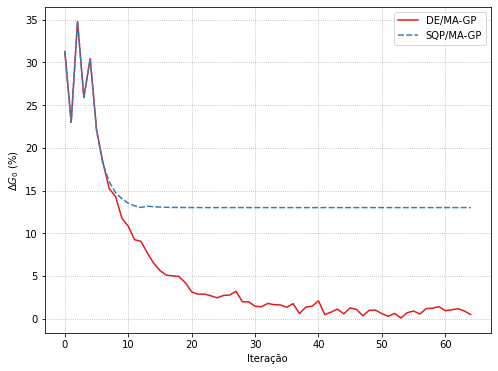

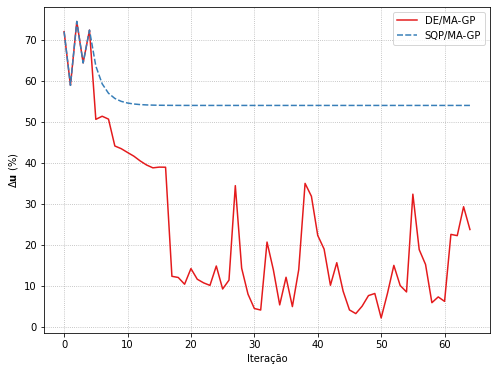

In [35]:
_, figa = analyzer.plot_by_iteration(results_ma_all, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_ma_all, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'rap_cenarioa_gap_obj.png'))
    figb.savefig(join(FIGURES_PATH, 'rap_cenarioa_gap_u.png'))

### Effect of Noise

The results above are for the scenario where we have no noise in the plant measuremets. Since this is not the reality, an interesting test is to check how it can impact the RTO performance. For that, we consider a 0.01 additive gaussian noise, but using the same parameters as the previous system.

In [6]:
# load the results
results_ma_de_noise = analyzer.load('MA-GP-DE+noise')
results_ma_sqp_noise = analyzer.load('MA-GP-SQP+noise')

results_processed_ma_de_noise = analyzer.pre_process(results_ma_de_noise, f_plant, u_plant)
results_processed_ma_sqp_noise = analyzer.pre_process(results_ma_sqp_noise, f_plant, u_plant)

results_processed_ma_de_noise['Cenário'] = 'DE/MA-GP'
results_processed_ma_sqp_noise['Cenário'] = 'SQP/MA-GP'

results_processed_ma_de_noise['Amostra'] = results_processed_ma_de_noise['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_ma_sqp_noise['Amostra'] = results_processed_ma_sqp_noise['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')


results_ma_noise_all = pd.concat([results_processed_ma_de_noise, results_processed_ma_sqp_noise], ignore_index=True)

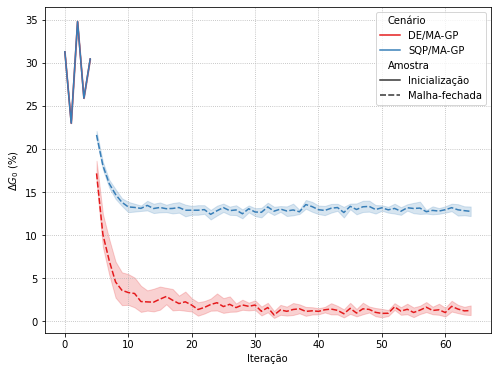

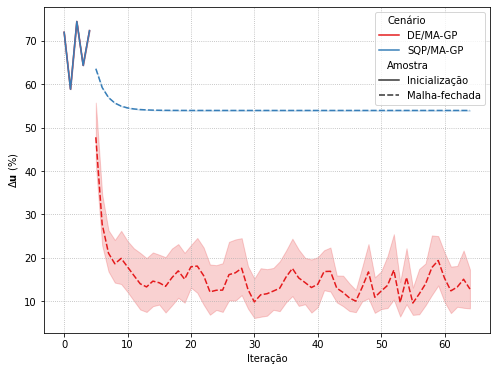

In [7]:
_, figa = analyzer.plot_by_iteration(results_ma_noise_all, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_ma_noise_all, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'rap_cenariob_gap_obj.png'))
    figb.savefig(join(FIGURES_PATH, 'rap_cenariob_gap_u.png'))

### Using different initial data points
We start to see more variation, but results are still equivalent for both cases. What if we initialized the system at different starting points?

In [8]:
# load the results
results_ma_de_noise_ds = analyzer.load('MA-GP-DE+noise-datasets')
results_ma_sqp_noise_ds = analyzer.load('MA-GP-SQP+noise-datasets')

results_processed_ma_de_noise_df = analyzer.pre_process(results_ma_de_noise_ds, f_plant, u_plant)
results_processed_ma_sqp_noise_df = analyzer.pre_process(results_ma_sqp_noise_ds, f_plant, u_plant)

results_processed_ma_de_noise_df['Cenário'] = 'DE/MA-GP'
results_processed_ma_sqp_noise_df['Cenário'] = 'SQP/MA-GP'

results_processed_ma_de_noise_df['Amostra'] = results_processed_ma_de_noise_df['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_ma_sqp_noise_df['Amostra'] = results_processed_ma_sqp_noise_df['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')


results_ma_noise_datasets_all = pd.concat([results_processed_ma_de_noise_df, results_processed_ma_sqp_noise_df], ignore_index=True)

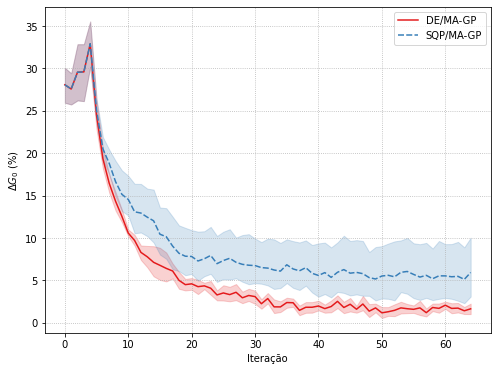

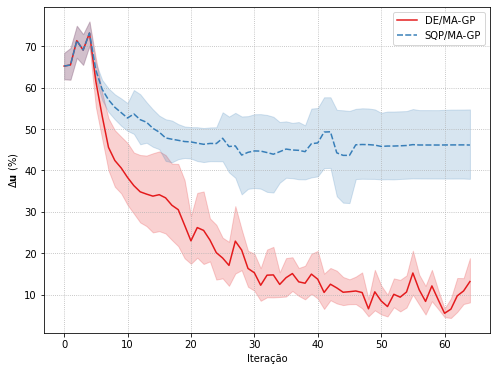

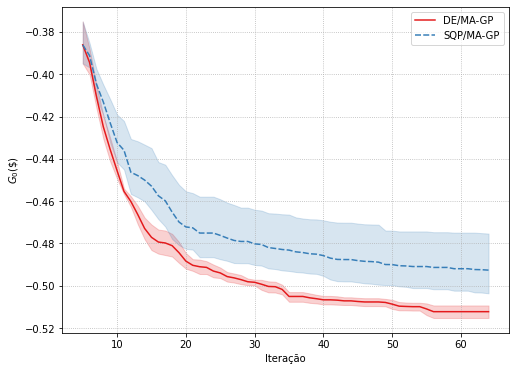

In [49]:
_, figa = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_ma_noise_datasets_all, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'rap_cenarioc_gap_obj.png'))
    figb.savefig(join(FIGURES_PATH, 'rap_cenarioc_gap_u.png'))
    figb.savefig(join(FIGURES_PATH, 'rap_cenarioc_best_solution.png'))

As seen in the images above, for the Williams-Otto problem, there is a very small effect on using different points for initialiazing the RTO system. Although there is some variation introduced by the measuremente noise,the system easily converges under both optimization algorithms. It is important to notice that this may not be entirely true if the problem exhibits more non-convexity, as investigated in [YY].

### Optimizer Choice

In [10]:
# load the results
analyzer = ExperimentAnalyzer(DATABASE)
results_bay_nm = analyzer.load('MA-GP-Bayesian-NM')
results_bay_de = analyzer.load('MA-GP-Bayesian-DE')
results_bay_sqp = analyzer.load('MA-GP-Bayesian-SQP')

results_processed_bay_de = analyzer.pre_process(results_bay_de, f_plant, u_plant)
results_processed_bay_sqp = analyzer.pre_process(results_bay_sqp, f_plant, u_plant)
results_processed_bay_nm = analyzer.pre_process(results_bay_nm, f_plant, u_plant)

results_processed_bay_de['Cenário'] = 'DE/MA-GP-EIC'
results_processed_bay_sqp['Cenário'] = 'SQP/MA-GP_EIC'
results_processed_bay_nm['Cenário'] = 'NM/MA-GP-EIC'

results_processed_bay_de['Amostra'] = results_processed_bay_de['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_bay_sqp['Amostra'] = results_processed_bay_sqp['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_processed_bay_nm['Amostra'] = results_processed_bay_nm['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')

results_bayes_all = pd.concat([results_processed_bay_de, results_processed_bay_sqp, results_processed_bay_nm], ignore_index=True)

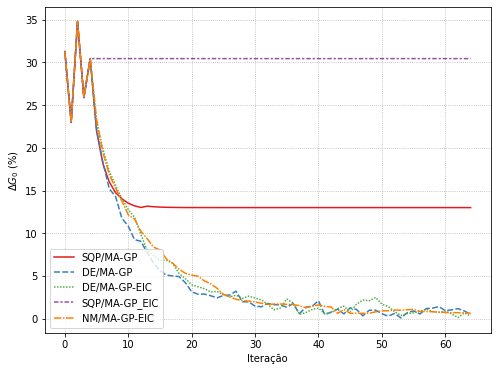

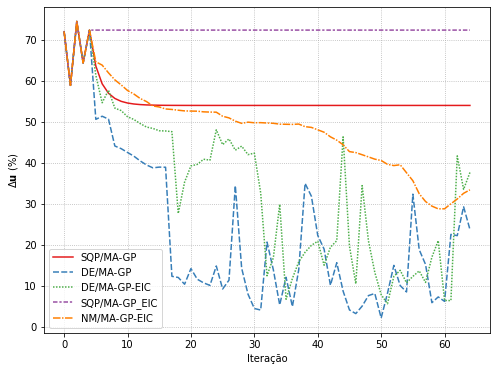

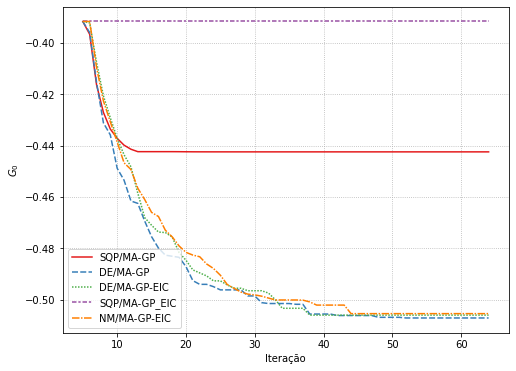

In [50]:
results_bayes_magp = pd.concat([results_processed_ma_sqp, results_processed_ma_de, results_processed_bay_de, results_processed_bay_sqp, results_processed_bay_nm], ignore_index=True)

_, figa = analyzer.plot_by_iteration(results_bayes_magp, 'dPhi', '$\Delta G_0$ (%)', '', style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_magp, 'du', '$\Delta \mathbf{u}$ (%)', '', style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_magp, 'best_plant_objective', '$G_0$', '', style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioa_gap_obj_all_rap.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioa_gap_u_all_rap.png'))
    figc.savefig(join(FIGURES_PATH, 'cenarioa_best_solution_all_rap.png'))

### Comparison with MA-GP

As seen before, SQP is unable to even find properly optimizer the EIC function. Therefore, we continue the remainder of this tutorial considering the DE algorithm as the default optimizer. Now, we comparte the results classic MA-GP scheme and with EIC acquisition function, considering the same experimental conditions.

The results for the cost and input optimality gap are displayed below. Notice that using the proposed Bayesian framework, we achieve similar results as the MA-GP baseline. However, the Bayesian approach presents more variability during the optimization steps, we could be related to the way we penalize the constraints violations. As seen previously, the optimal point will lie exactly at the intersection of two constraints, which poses a challenge for the RTO system. 

Another angle is to understand how the EIC acquisition function balances exploration and explotation. Maybe there is some exploitation happening when it shouldn't.

### Effect of initialization point EIC

As a last experiment, we analyze how the choice of initial operating points could affect the EIC RTO performance. The same initial points from the MA-GP experiment are used, and both approaches are compared.

In [17]:
results_bay_datasets_de = analyzer.load('MA-GP-Bayesian-DE+noise-datasets')
results_bay_datasets_nm = analyzer.load('MA-GP-Bayesian-NM+noise-datasets')
# results_bay_datasets_sqp = analyzer.load('MA-GP-Bayesian-SQP+noise-datasets')

# results_bay_processed_datasets_sqp = analyzer.pre_process(results_bay_datasets_sqp, f_plant, u_plant)
results_bay_processed_datasets_de = analyzer.pre_process(results_bay_datasets_de, f_plant, u_plant)
results_bay_processed_datasets_nm = analyzer.pre_process(results_bay_datasets_nm, f_plant, u_plant)

results_bay_processed_datasets_de['Cenário'] = 'DE/MA-GP-EIC'
results_bay_processed_datasets_nm['Cenário'] = 'NM/MA-GP-EIC'
# results_bay_processed_datasets_sqp['Cenário'] = 'SQP/NM/MA-GP-EIC'

# results_bay_processed_datasets_sqp['Amostra'] = results_bay_processed_datasets_sqp['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_bay_processed_datasets_de['Amostra'] = results_bay_processed_datasets_de['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')
results_bay_processed_datasets_nm['Amostra'] = results_bay_processed_datasets_nm['run.status'].map(lambda x: 'Inicialização' if x=='initialization' else 'Malha-fechada')


results_bayes_datasets = pd.concat([results_bay_processed_datasets_de, results_bay_processed_datasets_nm], ignore_index=True)
results_bayes_magp_datasets = pd.concat([results_processed_ma_de_noise_df, results_bay_processed_datasets_de], ignore_index=True)

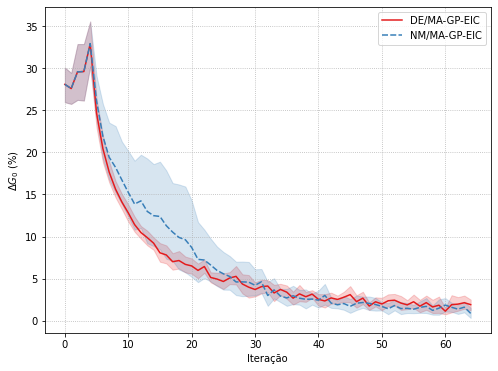

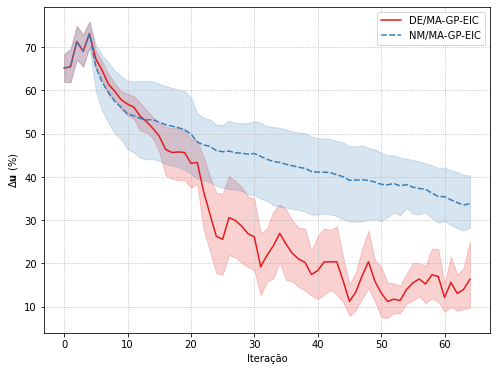

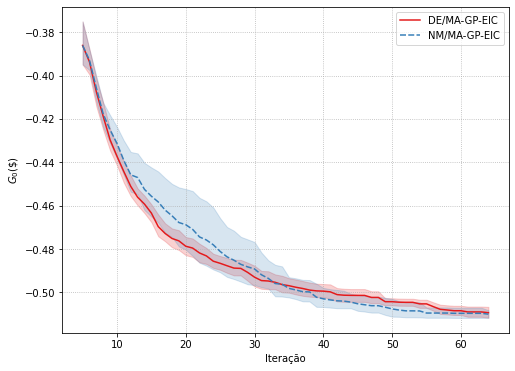

In [51]:
_, figa = analyzer.plot_by_iteration(results_bayes_datasets, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_datasets, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_datasets, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioc_gap_obj_eic_rap.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_gap_u_eic_rap.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_best_solution_eic_rap.png'))

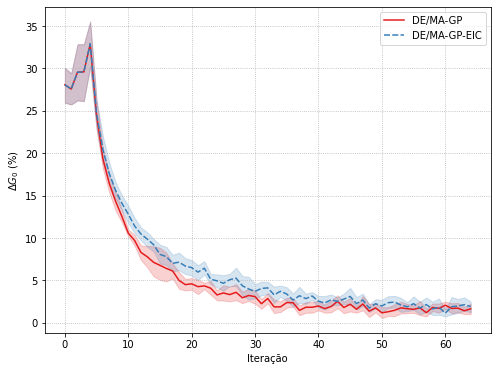

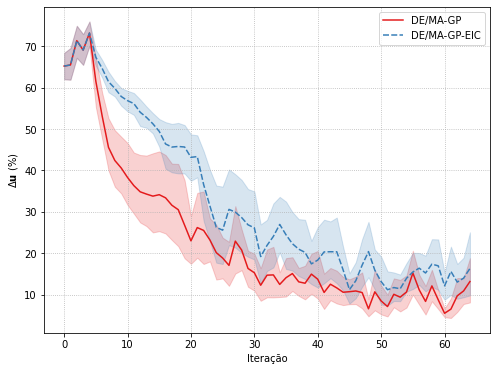

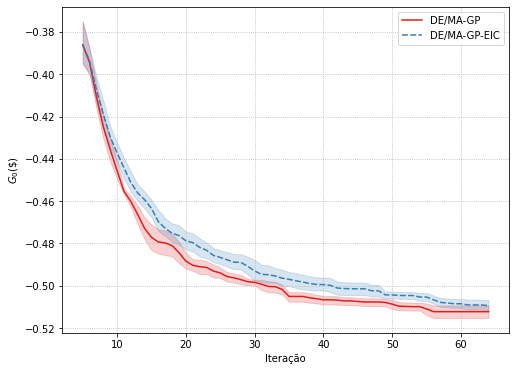

In [52]:
_, figa = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dPhi', '$\Delta G_0$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figb = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'du', '$\Delta \mathbf{u}$ (%)', '',style='Cenário', hue='Cenário', xlabel='Iteração')
_, figc = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'best_plant_objective', '$G_0 (\$)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')

if FIGURES_PATH is not None:
    figa.savefig(join(FIGURES_PATH, 'cenarioc_gap_obj_all_rap.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_gap_u_all_rap.png'))
    figb.savefig(join(FIGURES_PATH, 'cenarioc_best_solution_all_rap.png'))

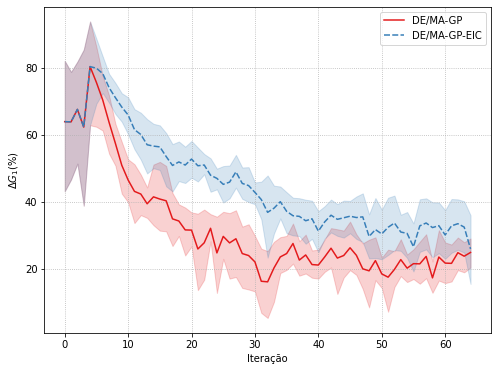

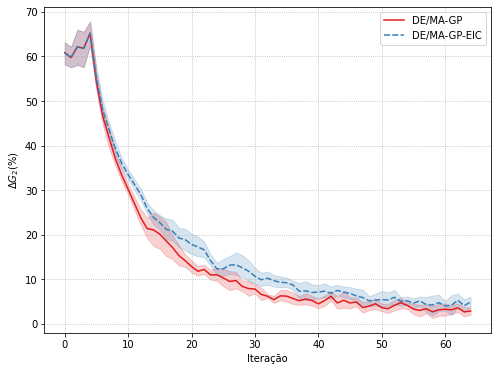

In [53]:
results_bayes_magp_datasets['dg0'] = results_bayes_magp_datasets[['g_0']].apply(lambda x: 100 * ((g[0] - x)/g[0]))
results_bayes_magp_datasets['dg1'] = results_bayes_magp_datasets[['g_1']].apply(lambda x: 100 * ((g[1] - x)/g[1]))
results_bayes_magp_datasets['dg'] = results_bayes_magp_datasets[['g_0','g_1']].apply(lambda x: 100 * np.linalg.norm((x - g)/g), axis=1)

axa, figa = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dg0', '$\Delta G_1 (\%)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')
axb, figb = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dg1', '$\Delta G_2 (\%)$', '',style='Cenário', hue='Cenário', xlabel='Iteração')
#axb, figb = analyzer.plot_by_iteration(results_bayes_magp_datasets, 'dg', '$\Delta G_p$', '',style='Amostra', hue='Cenário', xlabel='Iteração')

# axa.axhline(g[0], color='black', linestyle='-')
# axb.axhline(g[1], color='black', linestyle='-')

if FIGURES_PATH is not None:
   figa.savefig(join(FIGURES_PATH, 'cenarioc_g0_all_rap.png'))
   figb.savefig(join(FIGURES_PATH, 'cenarioc_g1_all_rap.png'))

## Time analsys

In [54]:
import seaborn as sns

def plot_execution_costs(data, suffix):
    figa, axa = plt.subplots(1, 1, figsize=(8, 6))
    figb, axb = plt.subplots(1, 1, figsize=(8, 6))
    
    data_plot = data[data['run.status'] != 'initialization']

    sns.boxplot(y='opt_time', data=data_plot, x='Cenário', showfliers=False, ax=axa, palette='Set1')
    axa.set_ylabel('Tempo [s]')
    sns.boxplot(y='n_fev', data=data_plot, x='Cenário', showfliers=False, ax=axb, palette='Set1')
    axb.set_ylabel('# avaliações do modelo')

    if FIGURES_PATH is not None:
        figa.savefig(join(FIGURES_PATH, f'opt_time_{suffix}.png'))
        figb.savefig(join(FIGURES_PATH, f'n_fev_{suffix}.png'))

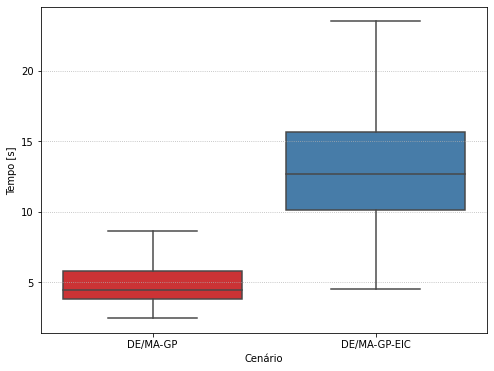

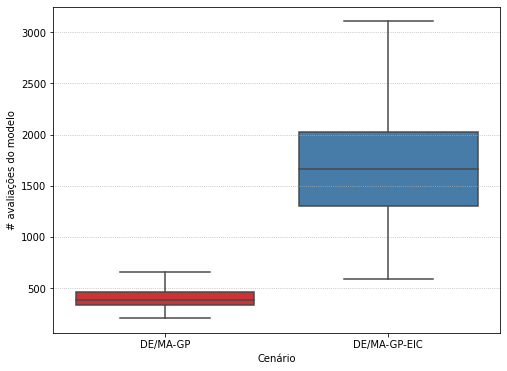

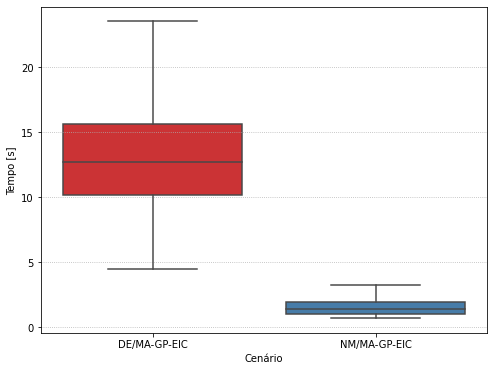

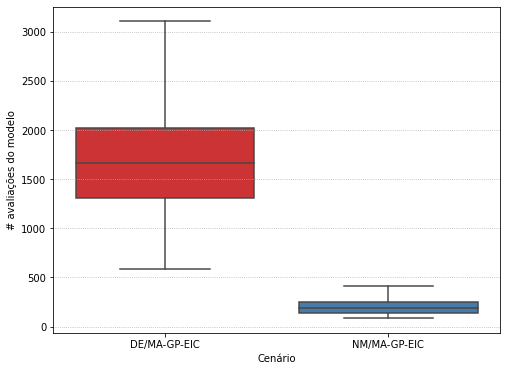

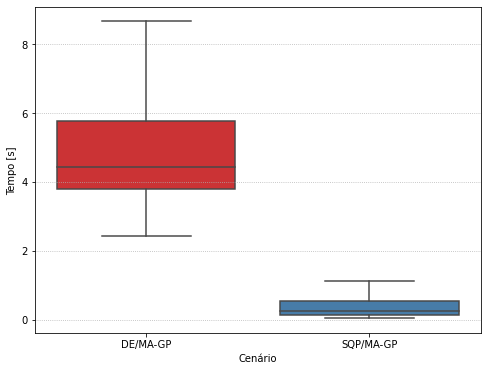

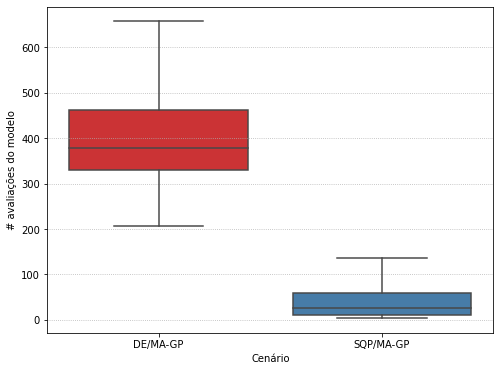

In [55]:
plot_execution_costs(results_bayes_magp_datasets, 'all_rap')
plot_execution_costs(results_bayes_datasets, 'eic_rap')
plot_execution_costs(results_ma_noise_datasets_all, 'rap')

In [33]:
results_all = pd.concat([results_processed_ma_de_noise_df, results_processed_ma_sqp_noise_df, results_bay_processed_datasets_de, results_bay_processed_datasets_nm], ignore_index=True)
results_all.where(results_all['run.status'] == 'closed-loop').groupby('Cenário')['opt_time'].agg(['mean','std','min','max']).to_latex('/mnt/d/textos-mestrado/dissertacao/tables/table_opt_time_rap.tex')

In [34]:
results_all.where(results_all['run.status'] == 'closed-loop').groupby('Cenário')['opt_time'].agg(['mean','std','min','max'])

,mean,std,min,max
Cenário,,,,
DE/MA-GP,4.952697,1.735899,2.444103,15.831395
DE/MA-GP-EIC,12.887131,5.482683,0.656714,45.943251
NM/MA-GP-EIC,1.562681,0.801482,0.704826,12.583654
SQP/MA-GP,0.881792,5.622304,0.052058,108.905422
